# Importing an `snnTorch` SNN model to LAVA and Running it

In [77]:
# Show current directory
import os
curr_dir = os.getcwd()
print(curr_dir)

# Check if the current WD is the file location
if "/thesis-lava/src/nir" not in os.getcwd():
    # Set working directory to this file location
    file_location = f"{os.getcwd()}/thesis-lava/src/nir"
    print("File Location: ", file_location)

    # Change the current working Directory
    os.chdir(file_location)

    # New Working Directory
    print("New Working Directory: ", os.getcwd())

/home/monkin/Desktop/feup/thesis/thesis-lava/src/nir


In [78]:
import numpy as np
import nir
import matplotlib.pyplot as plt

nir_network = nir.read("nir_model_cuba.nir")

In [79]:
# Print the network summary
print(f"NIR Network Info: Nº Nodes: {len(nir_network.nodes)} | Nº Edges: {len(nir_network.edges)}")

print(nir_network.nodes["2"])
print(nir_network.edges)


NIR Network Info: Nº Nodes: 6 | Nº Edges: 5
Linear(weight=array([[-0.0161455 ,  0.01705358,  0.01007112, ...,  0.00985886,
         0.03937952, -0.03549746],
       [ 0.03603304, -0.03541515,  0.01668479, ...,  0.04050541,
         0.0300939 ,  0.03487029],
       [ 0.03381281, -0.02337706,  0.02692366, ...,  0.02496983,
         0.03662976, -0.03068166],
       ...,
       [ 0.00337175,  0.01589908, -0.02817665, ...,  0.01133711,
        -0.01727862,  0.04292991],
       [-0.00492689,  0.03207321,  0.01319447, ..., -0.03240683,
         0.00964233, -0.03846167],
       [-0.01455489,  0.01560639, -0.02629465, ...,  0.03446307,
        -0.03139296,  0.00727098]], shape=(10, 500), dtype=float32), metadata={})
[('3', 'output'), ('input', '0'), ('2', '3'), ('1', '2'), ('0', '1')]


### How to fetch the number of neurons in each `NIR.CubaLIF` layer

In [80]:
nirLIF1 = nir_network.nodes["1"]
print(nirLIF1)

CubaLIF(tau_syn=np.float32(0.00014285714), tau_mem=np.float32(0.00012499999), r=np.float32(1.25), v_leak=np.float32(0.0), v_threshold=np.float32(1.0), w_in=np.float32(1.4285715), input_type={'input': array([], dtype=float64)}, output_type={'output': array([], dtype=float64)}, metadata={}, num_neurons=np.int64(500))


In [81]:

MANUAL_CREATION = True

if MANUAL_CREATION:
    # TODO: This is not the original code. I changed it because it had errors..
    """ ng = nir.NIRGraph(
        nodes={
            "input": nir.Input(input_type=np.array([3])),
            # "affine": nir.Affine(weight=np.array([[8, 2, 10], [14, 3, 14]]).T, bias=np.array([1, 2])),
            "lif": nir.CubaLIF(
                # tau=np.array([1] * 2),
                r=np.array([1 / 1e-4] * 2),
                tau_syn=np.array([1] * 2),
                tau_mem=np.array([1] * 2),
                v_leak=np.array([0] * 2),
                v_threshold=np.array([1] * 2),
            ),
            "out": nir.Output(np.array([3])),
        },
        edges=[
            # ("input", "affine"),
            # ("affine", "lif"),
            ("input", "lif"),
            ("lif", "out")
        ],
    ) """
    ng = nir.NIRGraph(
        nodes={
            "input": nir.Input(input_type=np.array([3])),
            "affine": nir.Affine(weight=np.array(
                [[8, 2, 10], [14, 3, 14]]).T, bias=np.array([0, 0])),
            "lif": nir.LIF(
                tau=np.array([1] * 2),
                r=np.array([1] * 2),
                v_leak=np.array([0] * 2),
                v_threshold=np.array([1] * 2),
            ),
            "output": nir.Output(np.array([3])),
        },
        edges=[(0, 1), (1, 2), (2, 3)],
    )

In [82]:
from nir_to_lava_edit import ImportConfig, LavaLibrary, import_from_nir
# from nir_to_lava import ImportConfig, LavaLibrary, import_from_nir

config = ImportConfig(
    dt=1e-4, fixed_pt=False, on_chip=False, library_preference=LavaLibrary.Lava,
)

In [83]:
nir2lava_network, startNodes, endNodes = import_from_nir(
    nir_network,  # ng, # 
    config
)

In [84]:
print(nir2lava_network)
print(startNodes)
print(endNodes)

{'0': <lava.proc.dense.process.Dense object at 0x7f635aae3340>, '1': [<lava.proc.dense.process.Dense object at 0x7f635aae3ca0>, <lava.proc.lif.process.LIF object at 0x7f635d22e470>], '2': <lava.proc.dense.process.Dense object at 0x7f635aae30d0>, '3': [<lava.proc.dense.process.Dense object at 0x7f635c4522c0>, <lava.proc.lif.process.LIF object at 0x7f635aae3eb0>]}
['0']
['3']


I was able to make it run without errors! However, it seems like the code to convert a NIR network to a LAVA network is not complete.

## How to Use the Lava Processes imported with NIR
It seems like `import_from_nir` returns a map containing the Lava Processes that were imported. Let's try to use them

### Print the ports of the Network Processes

In [85]:
from lava.magma.core.process.process import AbstractProcess

# Print the Network Ports
for key, proc in nir2lava_network.items():
    print(f"Key: {key} | Proc: {proc}")

    if isinstance(proc, list):
        # Network Node contains multiple Processes
        # Note: Max Depth is 2
        for inner_key,inner_proc in enumerate(proc):
            print(f"Key: ({key},{inner_key}) | Proc: {inner_proc}")
            # Print the Network Ports
            for port in inner_proc.in_ports:
                print(f"Proc: {inner_proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")
            for port in inner_proc.out_ports:
                print(f"Proc: {inner_proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")
    else:
        # Print the Network Ports
        for port in proc.in_ports:
            print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")
        for port in proc.out_ports:
            print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")

Key: 0 | Proc: <lava.proc.dense.process.Dense object at 0x7f635aae3340>
Proc: Process_33 Port Name: s_in  Size: 784
Proc: Process_33 Port Name: a_out Size: 500
Key: 1 | Proc: [<lava.proc.dense.process.Dense object at 0x7f635aae3ca0>, <lava.proc.lif.process.LIF object at 0x7f635d22e470>]
Key: (1,0) | Proc: <lava.proc.dense.process.Dense object at 0x7f635aae3ca0>
Proc: Process_35 Port Name: s_in  Size: 500
Proc: Process_35 Port Name: a_out Size: 500
Key: (1,1) | Proc: <lava.proc.lif.process.LIF object at 0x7f635d22e470>
Proc: cuba lif Port Name: a_in  Size: 500
Proc: cuba lif Port Name: s_out Size: 500
Key: 2 | Proc: <lava.proc.dense.process.Dense object at 0x7f635aae30d0>
Proc: Process_36 Port Name: s_in  Size: 500
Proc: Process_36 Port Name: a_out Size: 10
Key: 3 | Proc: [<lava.proc.dense.process.Dense object at 0x7f635c4522c0>, <lava.proc.lif.process.LIF object at 0x7f635aae3eb0>]
Key: (3,0) | Proc: <lava.proc.dense.process.Dense object at 0x7f635c4522c0>
Proc: Process_38 Port Name: s

## Connect the Processes

I'm not sure if the processes are already connected after importing them. **RE: Turns out they are**!! so we will comment the code that connects them.

In [86]:
# Start Process
startProc = nir2lava_network[startNodes[0]]
print(startProc)

In [87]:
lif1 = nir2lava_network["1"][1]
lif2 = nir2lava_network["3"][1]

print("lif1: ", lif1)
print("lif2: ", lif2)

lif1:  <lava.proc.lif.process.LIF object at 0x7f635d22e470>
lif2:  <lava.proc.lif.process.LIF object at 0x7f635aae3eb0>


In [88]:
# Test: Print the Ports of the Start Process
in_port = startProc.a_out if hasattr(startProc, "a_out") else startProc.s_out
out_port = startProc.a_in if hasattr(startProc, "a_in") else startProc.s_in

print("In Port: ", in_port)
print("Out Port: ", out_port)

In Port:  <lava.magma.core.process.ports.ports.OutPort object at 0x7f635aae3730>
Out Port:  <lava.magma.core.process.ports.ports.InPort object at 0x7f635aae3b20>


In [89]:
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.ports.ports import OutPort, InPort
"""
Given 2 processes, connect the output of the first process to the input of the second process
"""
def connectProcesses(proc1: AbstractProcess, proc2: AbstractProcess):
    # Each process may have different port names for the input and output ports

    # Get the output port of the first process: "Activation Out" | "Spike Out"
    outPort: OutPort  = proc1.a_out if hasattr(proc1, "a_out") else proc1.s_out
    # Get the input port of the second process: "Activation In" | "Spike In"
    inPort: InPort = proc2.a_in if hasattr(proc2, "a_in") else proc2.s_in

    # Connect the output of the first process to the input of the second process
    outPort.connect(inPort)

In [90]:
# Create the Input Process

# Connect the Layers
""" prevProc = None
for _key, proc in nir2lava_network.items():
    print(f"Key: {_key} | Proc: {proc}")
    if isinstance(proc, list):
        # Network Node contains multiple Processes
        # Note: Max Depth is 2
        for inner_proc in proc:
            print("connecting", prevProc, inner_proc)
            # Check if the Previous Process is None (First Layer)
            if prevProc is not None:
                # Connect the Processes
                connectProcesses(prevProc, inner_proc)

            # Update the Previous Process
            prevProc = inner_proc
    else:
        # Check if the Previous Process is None (First Layer)
        if prevProc is not None:
            # Connect the Processes
            connectProcesses(prevProc, proc)
        
        # Update the Previous Process
        prevProc = proc """


' prevProc = None\nfor _key, proc in nir2lava_network.items():\n    print(f"Key: {_key} | Proc: {proc}")\n    if isinstance(proc, list):\n        # Network Node contains multiple Processes\n        # Note: Max Depth is 2\n        for inner_proc in proc:\n            print("connecting", prevProc, inner_proc)\n            # Check if the Previous Process is None (First Layer)\n            if prevProc is not None:\n                # Connect the Processes\n                connectProcesses(prevProc, inner_proc)\n\n            # Update the Previous Process\n            prevProc = inner_proc\n    else:\n        # Check if the Previous Process is None (First Layer)\n        if prevProc is not None:\n            # Connect the Processes\n            connectProcesses(prevProc, proc)\n        \n        # Update the Previous Process\n        prevProc = proc '

## Create Input Process to feed the network

In [91]:
from lava.proc.spiker.process import Spiker

# Create Processes
input_layer = Spiker(
    shape=(500,),
    name="input_layer",
    payload=1,
    period=2    # First spike is emmitted at time step period + 1
)

In [92]:
# Connect the Input Layer to the First Layer
input_layer.s_out.connect(in_port)

# Run the Network

## Record Internal Variables

In [93]:
from lava.proc.monitor.process import Monitor

monitor_lif1_v = Monitor()
monitor_lif1_u = Monitor()

monitor_lif2_v = Monitor()
monitor_lif2_u = Monitor()

num_steps = 20     # TODO: Check the number of steps to run the simulation for

# Connect the monitors to the variables we want to monitor
monitor_lif1_v.probe(lif1.v, num_steps)
monitor_lif1_u.probe(lif1.u, num_steps)

monitor_lif2_v.probe(lif2.v, num_steps)
monitor_lif2_u.probe(lif2.u, num_steps)

In [94]:
from lava.magma.core.run_conditions import RunContinuous, RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg

# run_condition = RunContinuous()   # TODO: Change to this one
run_condition = RunSteps(num_steps=num_steps)
run_cfg = Loihi1SimCfg(select_tag="floating_pt")   # TODO: Check why we need this select_tag="floating_pt"

In [95]:
input_layer.run(condition=run_condition, run_cfg=run_cfg)

## Retrieve Recorded Data

In [96]:
data_lif1_v = monitor_lif1_v.get_data()
data_lif1_u = monitor_lif1_u.get_data()

data_lif2_v = monitor_lif2_v.get_data()
data_lif2_u = monitor_lif2_u.get_data()

data_lif1 = data_lif1_v.copy()
data_lif1["cuba lif"]["u"] = data_lif1_u["cuba lif"]["u"]   # Merge the dictionaries to contain both voltage and current

data_lif2 = data_lif2_v.copy()
data_lif2["cuba lif"]["u"] = data_lif2_u["cuba lif"]["u"]   # Merge the dictionaries to contain both voltage and current

In [97]:
data_lif1

{'cuba lif': {'v': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         ...,
         [0.97069598, 0.97069598, 0.97069598, ..., 0.97069598, 0.97069598,
          0.97069598],
         [0.45787546, 0.45787546, 0.45787546, ..., 0.45787546, 0.45787546,
          0.45787546],
         [0.97069599, 0.97069599, 0.97069599, ..., 0.97069599, 0.97069599,
          0.97069599]], shape=(20, 500)),
  'u': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         ...,
         [0.8791209 , 0.8791209 , 0.8791209 , ...

In [98]:
data_lif2

{'cuba lif': {'v': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 

## Plot the Recorded Data

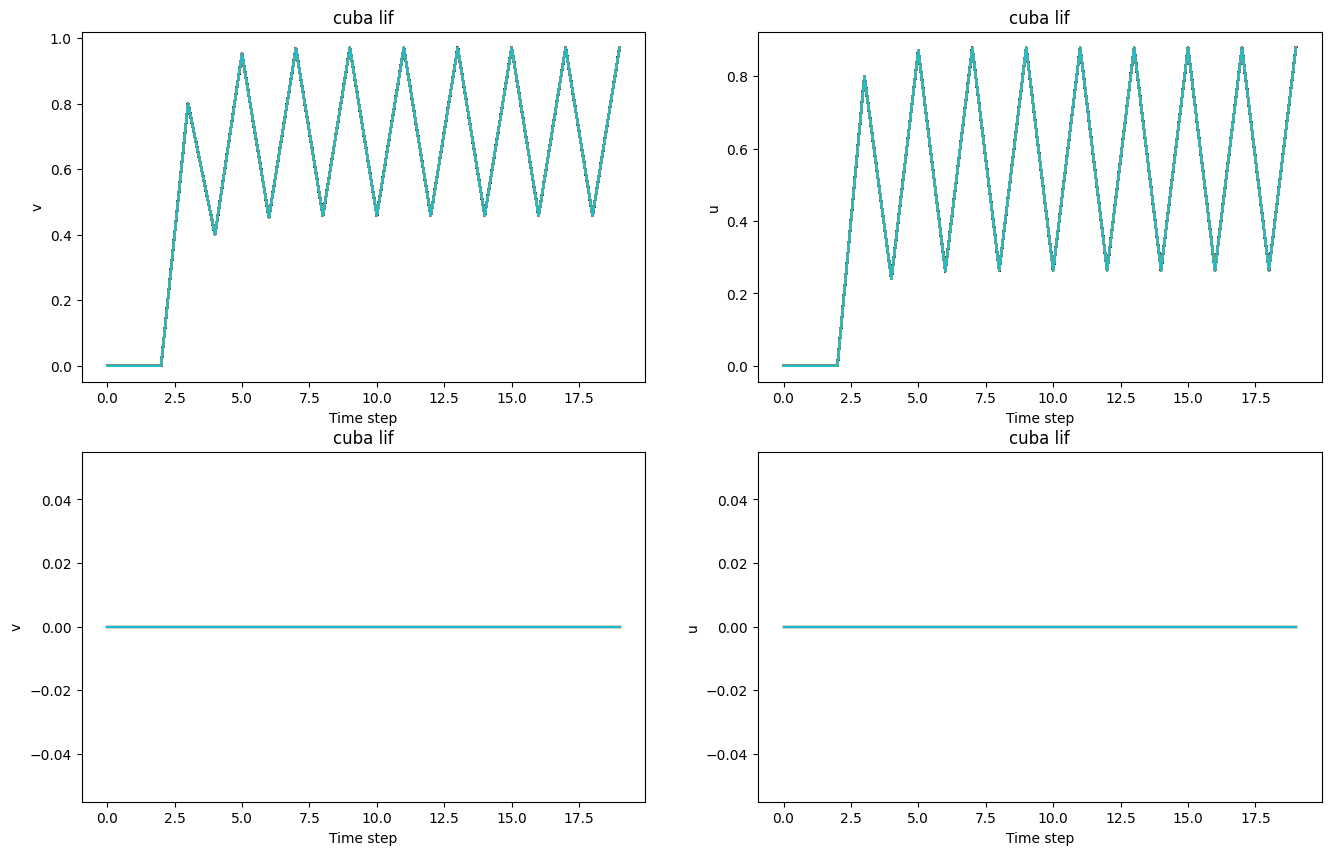

In [100]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

# Create a subplot for each monitored variable
fig = plt.figure(figsize=(16, 10))
ax0 = fig.add_subplot(2, 2, 1)
ax0.set_title('LIF1 Voltage (V) / time step')
ax1 = fig.add_subplot(2, 2, 2)
ax1.set_title('LIF1 Current (U) / time step')
ax2 = fig.add_subplot(2, 2, 3)
ax2.set_title('LIF2 Voltage (V) / time step')
ax3 = fig.add_subplot(2, 2, 4)
ax3.set_title('LIF2 Current (U) / time step')

# Plot the data
monitor_lif1_v.plot(ax0, lif1.v)
monitor_lif1_u.plot(ax1, lif1.u)
monitor_lif2_v.plot(ax2, lif2.v)
monitor_lif2_u.plot(ax3, lif2.u)


# Notes
- To import an `snn-torch` model using `NIR`, I had to modify `nir_to_lava`, `snntorch`, `nir`, and also `nirtorch` source code.  